# Demo
This notebook offers a guided tour for reading data, examining visualizations, fine-tuning models, and contrasting outcomes.

In [1]:
from os.path import join,basename
import pandas as pd
import json

In [2]:
## render Vega-Lite visualization; recommended in the Jupyter Lab
def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    
    display(bundle, raw = True)

## 0. Read benchmark datasets

In [3]:
dataset_name = 'CVPT'
folder = join('datasets', dataset_name)

In [4]:
## read the corpus sheet
df = pd.read_csv(join(folder, 'corpus.csv'))

In [5]:
## the corpus sheet has four major entries
## utterance: the NL utterance
## visId: the id of each testcase
## gt: the ground-truth visualization, excluding the data entry 
## dataset: the dataset used for render this chart
df.head(2)

,utterance,visId,gt,dataset,gtId,id
0,Visualize the count of positions with a pie ch...,exp-0,"{'mark': {'type': 'arc'}, 'encoding': {'theta'...",rov,exp-0,exp-0
1,Could you draw a line chart with points that s...,exp-1,"{'mark': {'type': 'line', 'point': True}, 'enc...",nba_cleaned,exp-1,exp-1


In [6]:
## datasets used to render the charts
datasets = json.load(open(join(folder, 'datasets.json')))

In [7]:
## a helper function for combining Vega-Lite code and dataset
def render_chart(vSpec, dataset):
    vSpec['data'] = {
        'values': dataset
    }
    VegaLite(vSpec)

Could you draw a line chart with points that show the average points per game for each team in different areas?


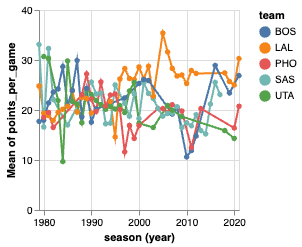

In [8]:
## display one example
example = df.loc[1,:]
vSpec = eval(example['gt'])
dataset = datasets[example.dataset]

print(example.utterance)
render_chart(vSpec, dataset)

## 1. Benchmark

In [9]:
## read the file and read one example
benchmarks = json.load(open(join(folder, 'gptResult.json')))

## sample one
idx, obj = list(benchmarks.items())[0]

In [10]:
## the information for this chart
print(idx) 
print(obj['info']['utterance'])
print(obj['info']['gt'])
print(obj['info']['dataset'])

exp-405
Create a scatterplot with dacoity and other cases as the axes, and the size representing the counts. Bin both continous variables?
{'mark': {'type': 'point'}, 'encoding': {'x': {'bin': {'maxbins': 10}, 'field': 'other_cases'}, 'y': {'bin': {'maxbins': 10}, 'field': 'dacoity'}, 'size': {'aggregate': 'count'}}, 'data': {'url': 'crime_data_bangladesh.json'}}
crime_data_bangladesh


In [11]:
## read the benchmark results - it consists of five methods
## basic: the baseline GPT-3 Dacinvi model
## fewshot-1: fewshot learning with 1 example
## fewshot-3: fewshot learning with 3 example
## fewshot-5: fewshot learning with 5 example
benchmarks = obj['testcase']

In [12]:
## a helper function to cast GPT response as json
def response_to_json(response):
    try:
        vl = response.strip().replace('None', "null").replace('True', 'true').replace('False', 'false').replace("'", '"')
        vl = json.loads(vl)
    except Exception as e:
        print('syntax error', e)
        vl = {}
    return vl

In [13]:
## Let us check the basic version first
test_type = 'basic' ## other options: 'fewshot-1', 'fewshot-3', 'fewshot-5', 'finetune'
dataset_used = obj['info']['dataset']

print('=======The above is exactly the prompt fed into GPT=======')
print(benchmarks[test_type]['prompt'])

print('=======The above is exactly the response from GPT=======')
print(benchmarks[test_type]['response'])

=======The above is exactly the prompt fed into GPT=======
Task: Create a scatterplot with dacoity and other cases as the axes, and the size representing the counts. Bin both continous variables?. This is a sample of the dataset named crime_data_bangladesh.csv: {'area_name': 'dhaka metropolitan', 'year': 2010, 'dacoity': 47, 'robbery ': 220, 'murder': 245, 'speedy_trial': 363, 'riot ': 3, 'woman_child_repression': 1370, 'kidnapping': 139, 'police_assault': 155, 'burglary': 555, 'theft': 1915, 'other_cases': 7228, 'recovery_cases_arms_act': 518, 'recovery_cases_explosive': 82, 'recovery_cases_narcotics': 10535, 'recovery_cases_smuggling': 144}. 
Vega-Lite code:
=======The above is exactly the response from GPT=======


{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {
    "values": [
      {
        "area_name": "dhaka metropolitan",
        "year": 2010,
        "dacoity": 47,
        "robbery": 220,
        "murder": 245,
        "speedy_trial": 363,
      

Create a scatterplot with dacoity and other cases as the axes, and the size representing the counts. Bin both continous variables?


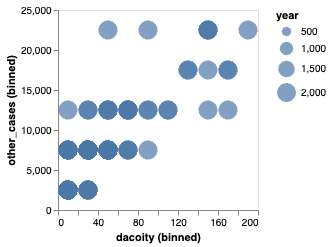

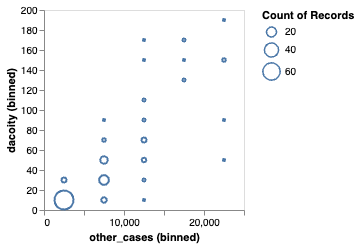

In [14]:
## render the chart
print(obj['info']['utterance'])
vSpec = response_to_json(benchmarks[test_type]['response'])
render_chart(vSpec, datasets[dataset_used])

## compare with the ground-truth
gt_vSpec = eval(obj['info']['gt'])
render_chart(gt_vSpec, datasets[dataset_used])

## in this case, we see that the basic model makes an error in the size encoding. The ground-truth askes for counts, while the GPT-3 response encodes a year field.

Create a scatterplot with dacoity and other cases as the axes, and the size representing the counts. Bin both continous variables?


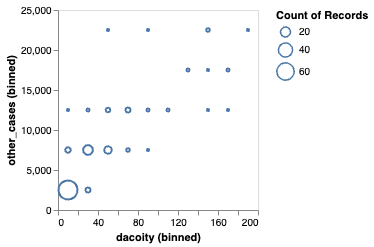

In [15]:
## The fine-tuned model generates the accurate result!
print(obj['info']['utterance'])
test_type = 'finetune'
vSpec = response_to_json(benchmarks[test_type]['response'])
render_chart(vSpec, datasets[dataset_used])